<a href="https://colab.research.google.com/github/Horax02/Artificial_Vision-Mitnicks/blob/main/HT_basty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Canny Edge Detection

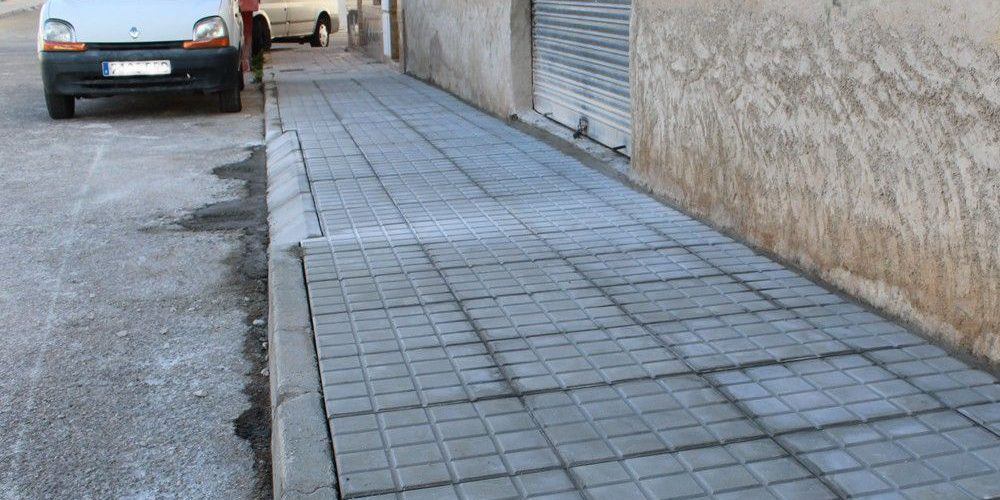

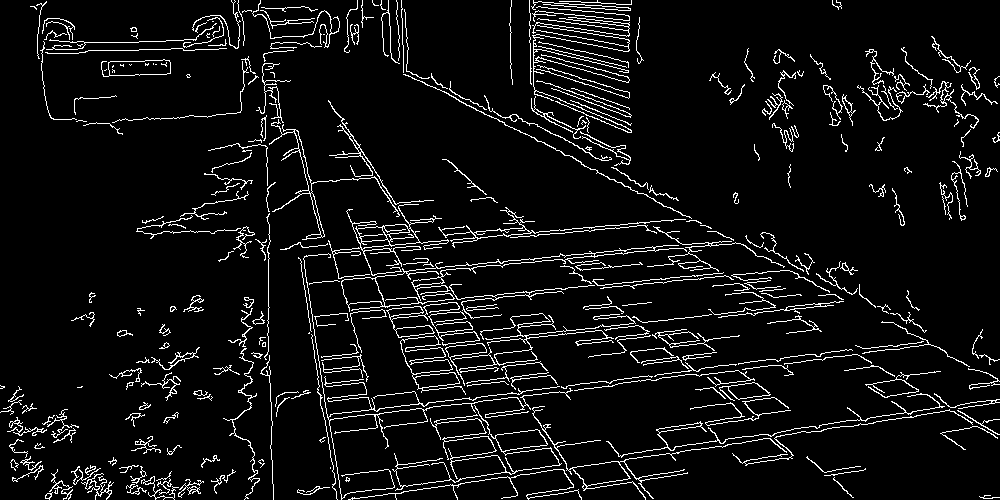

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Leer la imagen
image = cv2.imread("/content/ayto-aceras-2-1000x500.jpg")

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar un suavizado para reducir el ruido
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar el algoritmo de detección de bordes Canny
edges = cv2.Canny(blurred, 50, 150)  # Ajusta los umbrales según tus necesidades

# Mostrar la imagen original y los bordes detectados
cv2_imshow(image)
cv2_imshow(edges)

## Hough Transform for Lines

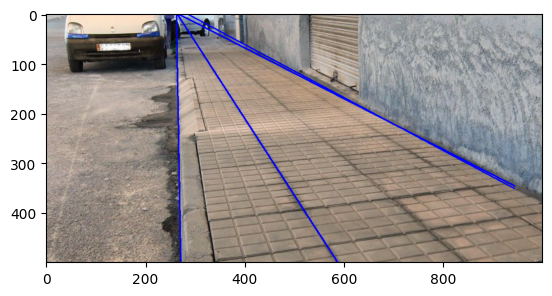

In [ ]:
import matplotlib.pyplot as plt
# Define the Hough transform parameters
# Make a copy the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 200

line_image = np.copy(image) #creating an image copy to draw lines on

# Run Hough on the edge-detected image
lines = cv2.HoughLines(edges, rho, theta, threshold)

# Iterate over the output "lines" and draw lines on the image copy
if lines is not None:
  for line in lines:
    # Stores the value of cos(theta) in a and sin(theta) in b
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)

    # x0 stores the value rcos(theta) and y0 stores the value rsin(theta) 
    x0 = a*rho
    y0 = b*rho
    
    # rounded off the values
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calcular el ángulo en radianes utilizando arctan2() de NumPy
    angle_rad = np.arctan2(delta_y, delta_x)

    # Convertir el ángulo a grados
    angle_deg = np.degrees(angle_rad)
    

    # cv2.line draws a line in line_image from the point(x1,y1) to (x2,y2). 
    # (0,0,255) denotes the colour of the line and 2 denotes the thickness. 
    if angle_deg>10:
      cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),2)
    
plt.imshow(line_image)

## Semantic Segmentation (Intento)

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


RuntimeError: ignored

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('ayto-aceras-2-1000x500.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

RuntimeError: ignored

In [ ]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

NameError: ignored